In [1]:

# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

In [2]:
# import dataset from CSV file
df = pd.read_csv('data/Train.csv')
print(df.shape)
df.head(10)

(30557, 82)


,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,010Q650 X 2020-01-07,2020-01-07,010Q650,28.0,10.0,52.0,1053.22,94,14.600000,42.200001,...,30.605176,-62.134264,23.419991,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,010Q650 X 2020-01-08,2020-01-08,010Q650,21.0,6.0,51.0,1239.66,96,15.600000,47.100002,...,60.866484,-71.908414,32.348835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,010Q650 X 2020-01-09,2020-01-09,010Q650,18.0,6.0,28.0,307.93,93,18.600000,62.400002,...,59.674296,-60.765053,26.396956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,010Q650 X 2020-01-10,2020-01-10,010Q650,21.0,15.0,33.0,305.92,95,11.800000,39.000000,...,37.176703,-73.812750,31.707143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,010Q650 X 2020-01-11,2020-01-11,010Q650,24.0,16.0,32.0,279.19,85,10.396144,33.100002,...,10.016394,-68.586306,28.090359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [3]:
citys = df.Place_ID.unique()
li = random.sample(range(1, 339), 10)
print(li)
for i in li:
    df_city_i = df[df.Place_ID == citys[i]]
    print(f"City {i}: {df_city_i.shape}")


[164, 317, 299, 297, 330, 72, 166, 336, 88, 291]
City 164: (94, 82)
City 317: (94, 82)
City 299: (94, 82)
City 297: (48, 82)
City 330: (94, 82)
City 72: (12, 82)
City 166: (94, 82)
City 336: (94, 82)
City 88: (94, 82)
City 291: (79, 82)


In [ ]:
# plot histplots target variable for each df_city_i in sublots
for i in li:
    df_city_i = df[df.Place_ID == citys[i]]
    plt.figure(figsize=(10, 5))
    sns.histplot(df_city_i['target'], kde=True)
    plt.title(f"Target Distribution for City {i}")
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.show()



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

In [6]:
# calculate the sum and percentage of NaN values in each column
def nans_sum_perc(x):
    nans_sum_perc_d = {}
    for i in x.columns:
        sum_nan = x[i].isna().sum() 
        if  sum_nan > 0:
            perc_nan = round((sum_nan / x[i].shape[0]) * 100, 2)
            nans_sum_perc_d.update({i: [sum_nan, perc_nan]})
    return pd.DataFrame.from_dict(nans_sum_perc_d, orient='index', columns=['NaN Count', 'NaN %'])

nans_sum_perc(df)

,NaN Count,NaN %
L3_NO2_NO2_column_number_density,2189,7.16
L3_NO2_NO2_slant_column_number_density,2189,7.16
L3_NO2_absorbing_aerosol_index,2189,7.16
L3_NO2_cloud_fraction,2189,7.16
L3_NO2_sensor_altitude,2189,7.16
...,...,...
L3_CH4_aerosol_optical_depth,24765,81.05
L3_CH4_sensor_azimuth_angle,24765,81.05
L3_CH4_sensor_zenith_angle,24765,81.05
L3_CH4_solar_azimuth_angle,24765,81.05


In [7]:
sat_data = [col for col in df.columns if 'sensor_azimu' in col.lower()]
df[sat_data].head(10)

,L3_NO2_sensor_azimuth_angle,L3_O3_sensor_azimuth_angle,L3_CO_sensor_azimuth_angle,L3_HCHO_sensor_azimuth_angle,L3_CLOUD_sensor_azimuth_angle,L3_AER_AI_sensor_azimuth_angle,L3_SO2_sensor_azimuth_angle,L3_CH4_sensor_azimuth_angle
0,76.537512,76.536426,74.543393,76.536426,76.536426,76.537512,76.536426,74.481049
1,-14.708036,-14.708036,-57.015200,-14.708036,-14.708036,-14.708036,-14.708036,75.630043
2,-105.201338,-105.201338,-103.494458,-105.201338,-105.201338,-105.201338,-105.201338,NaN
3,-104.334056,-104.334066,-101.955931,-104.334066,-104.334066,-104.334056,-104.334066,NaN
4,58.850179,58.850179,15.499573,58.850179,58.850179,58.850179,58.850179,NaN
5,76.387678,76.387658,74.053369,76.387658,76.387658,76.387658,76.387658,NaN
6,-6.120488,-6.118364,75.304084,-106.238308,-6.118364,-6.120488,-41.126184,NaN
7,-13.662432,-13.662432,-13.663531,-13.662432,-13.662432,-13.662432,-13.662432,NaN
8,-104.544468,-104.544468,-102.555174,-104.544468,-104.544468,-104.544468,-104.544468,NaN
9,-104.110578,-104.110578,-97.761258,-104.110578,-104.110578,-104.110578,-104.110578,0.000000


In [8]:
# RegEx-Pattern for all columns starting with "L3_" 
l3_pattern = r"^L3_"

# remove all columns starting with "L3_"
columns_without_l3 = [col for col in df.columns if not re.search(l3_pattern, col)]

# drop IDs and target add-ons
cols_to_remove = ["Place_ID X Date", "Date", "target_min", "target_max", "target_variance", "target_count"]
columns_weather_target = [col for col in columns_without_l3 if col not in cols_to_remove]
print(*columns_weather_target, sep="\n")


Place_ID
target
precipitable_water_entire_atmosphere
relative_humidity_2m_above_ground
specific_humidity_2m_above_ground
temperature_2m_above_ground
u_component_of_wind_10m_above_ground
v_component_of_wind_10m_above_ground


In [9]:
# RegEx-Pattern für Spalten die mit "L3_" beginnen UND NICHT sensor/azimuth/zenith enthalten
l3_without_sensors_pattern = r"^L3_(?!.*(sensor|azimuth|zenith))"

# Behalte nur L3-Spalten ohne Sensor-Daten
l3_columns_without_sensors = [col for col in df.columns if re.search(l3_without_sensors_pattern, col, re.IGNORECASE)]

print(f"L3-Spalten ohne Sensoren: {len(l3_columns_without_sensors)}")
print(*l3_columns_without_sensors, sep="\n")

L3-Spalten ohne Sensoren: 33
L3_NO2_NO2_column_number_density
L3_NO2_NO2_slant_column_number_density
L3_NO2_absorbing_aerosol_index
L3_NO2_cloud_fraction
L3_NO2_stratospheric_NO2_column_number_density
L3_NO2_tropopause_pressure
L3_NO2_tropospheric_NO2_column_number_density
L3_O3_O3_column_number_density
L3_O3_O3_effective_temperature
L3_O3_cloud_fraction
L3_CO_CO_column_number_density
L3_CO_H2O_column_number_density
L3_CO_cloud_height
L3_HCHO_HCHO_slant_column_number_density
L3_HCHO_cloud_fraction
L3_HCHO_tropospheric_HCHO_column_number_density
L3_HCHO_tropospheric_HCHO_column_number_density_amf
L3_CLOUD_cloud_base_height
L3_CLOUD_cloud_base_pressure
L3_CLOUD_cloud_fraction
L3_CLOUD_cloud_optical_depth
L3_CLOUD_cloud_top_height
L3_CLOUD_cloud_top_pressure
L3_CLOUD_surface_albedo
L3_AER_AI_absorbing_aerosol_index
L3_SO2_SO2_column_number_density
L3_SO2_SO2_column_number_density_amf
L3_SO2_SO2_slant_column_number_density
L3_SO2_absorbing_aerosol_index
L3_SO2_cloud_fraction
L3_CH4_CH4_col

In [10]:
# # remove all data that is not recommended key measurements
# density_pattern = r"(column_number_density$|tropospheric_.*_column_number_density$)"

# final_columns_L3 = [col for col in columns_without_sensors if re.search(density_pattern, col)]

In [11]:
# add the final columns to the DataFrame
df_filtered = df[columns_weather_target + l3_columns_without_sensors]

print(f"Final dataFrame shape: {df_filtered.shape}")
print(*df_filtered.columns, sep='\n')

Final dataFrame shape: (30557, 41)
Place_ID
target
precipitable_water_entire_atmosphere
relative_humidity_2m_above_ground
specific_humidity_2m_above_ground
temperature_2m_above_ground
u_component_of_wind_10m_above_ground
v_component_of_wind_10m_above_ground
L3_NO2_NO2_column_number_density
L3_NO2_NO2_slant_column_number_density
L3_NO2_absorbing_aerosol_index
L3_NO2_cloud_fraction
L3_NO2_stratospheric_NO2_column_number_density
L3_NO2_tropopause_pressure
L3_NO2_tropospheric_NO2_column_number_density
L3_O3_O3_column_number_density
L3_O3_O3_effective_temperature
L3_O3_cloud_fraction
L3_CO_CO_column_number_density
L3_CO_H2O_column_number_density
L3_CO_cloud_height
L3_HCHO_HCHO_slant_column_number_density
L3_HCHO_cloud_fraction
L3_HCHO_tropospheric_HCHO_column_number_density
L3_HCHO_tropospheric_HCHO_column_number_density_amf
L3_CLOUD_cloud_base_height
L3_CLOUD_cloud_base_pressure
L3_CLOUD_cloud_fraction
L3_CLOUD_cloud_optical_depth
L3_CLOUD_cloud_top_height
L3_CLOUD_cloud_top_pressure
L3_CL

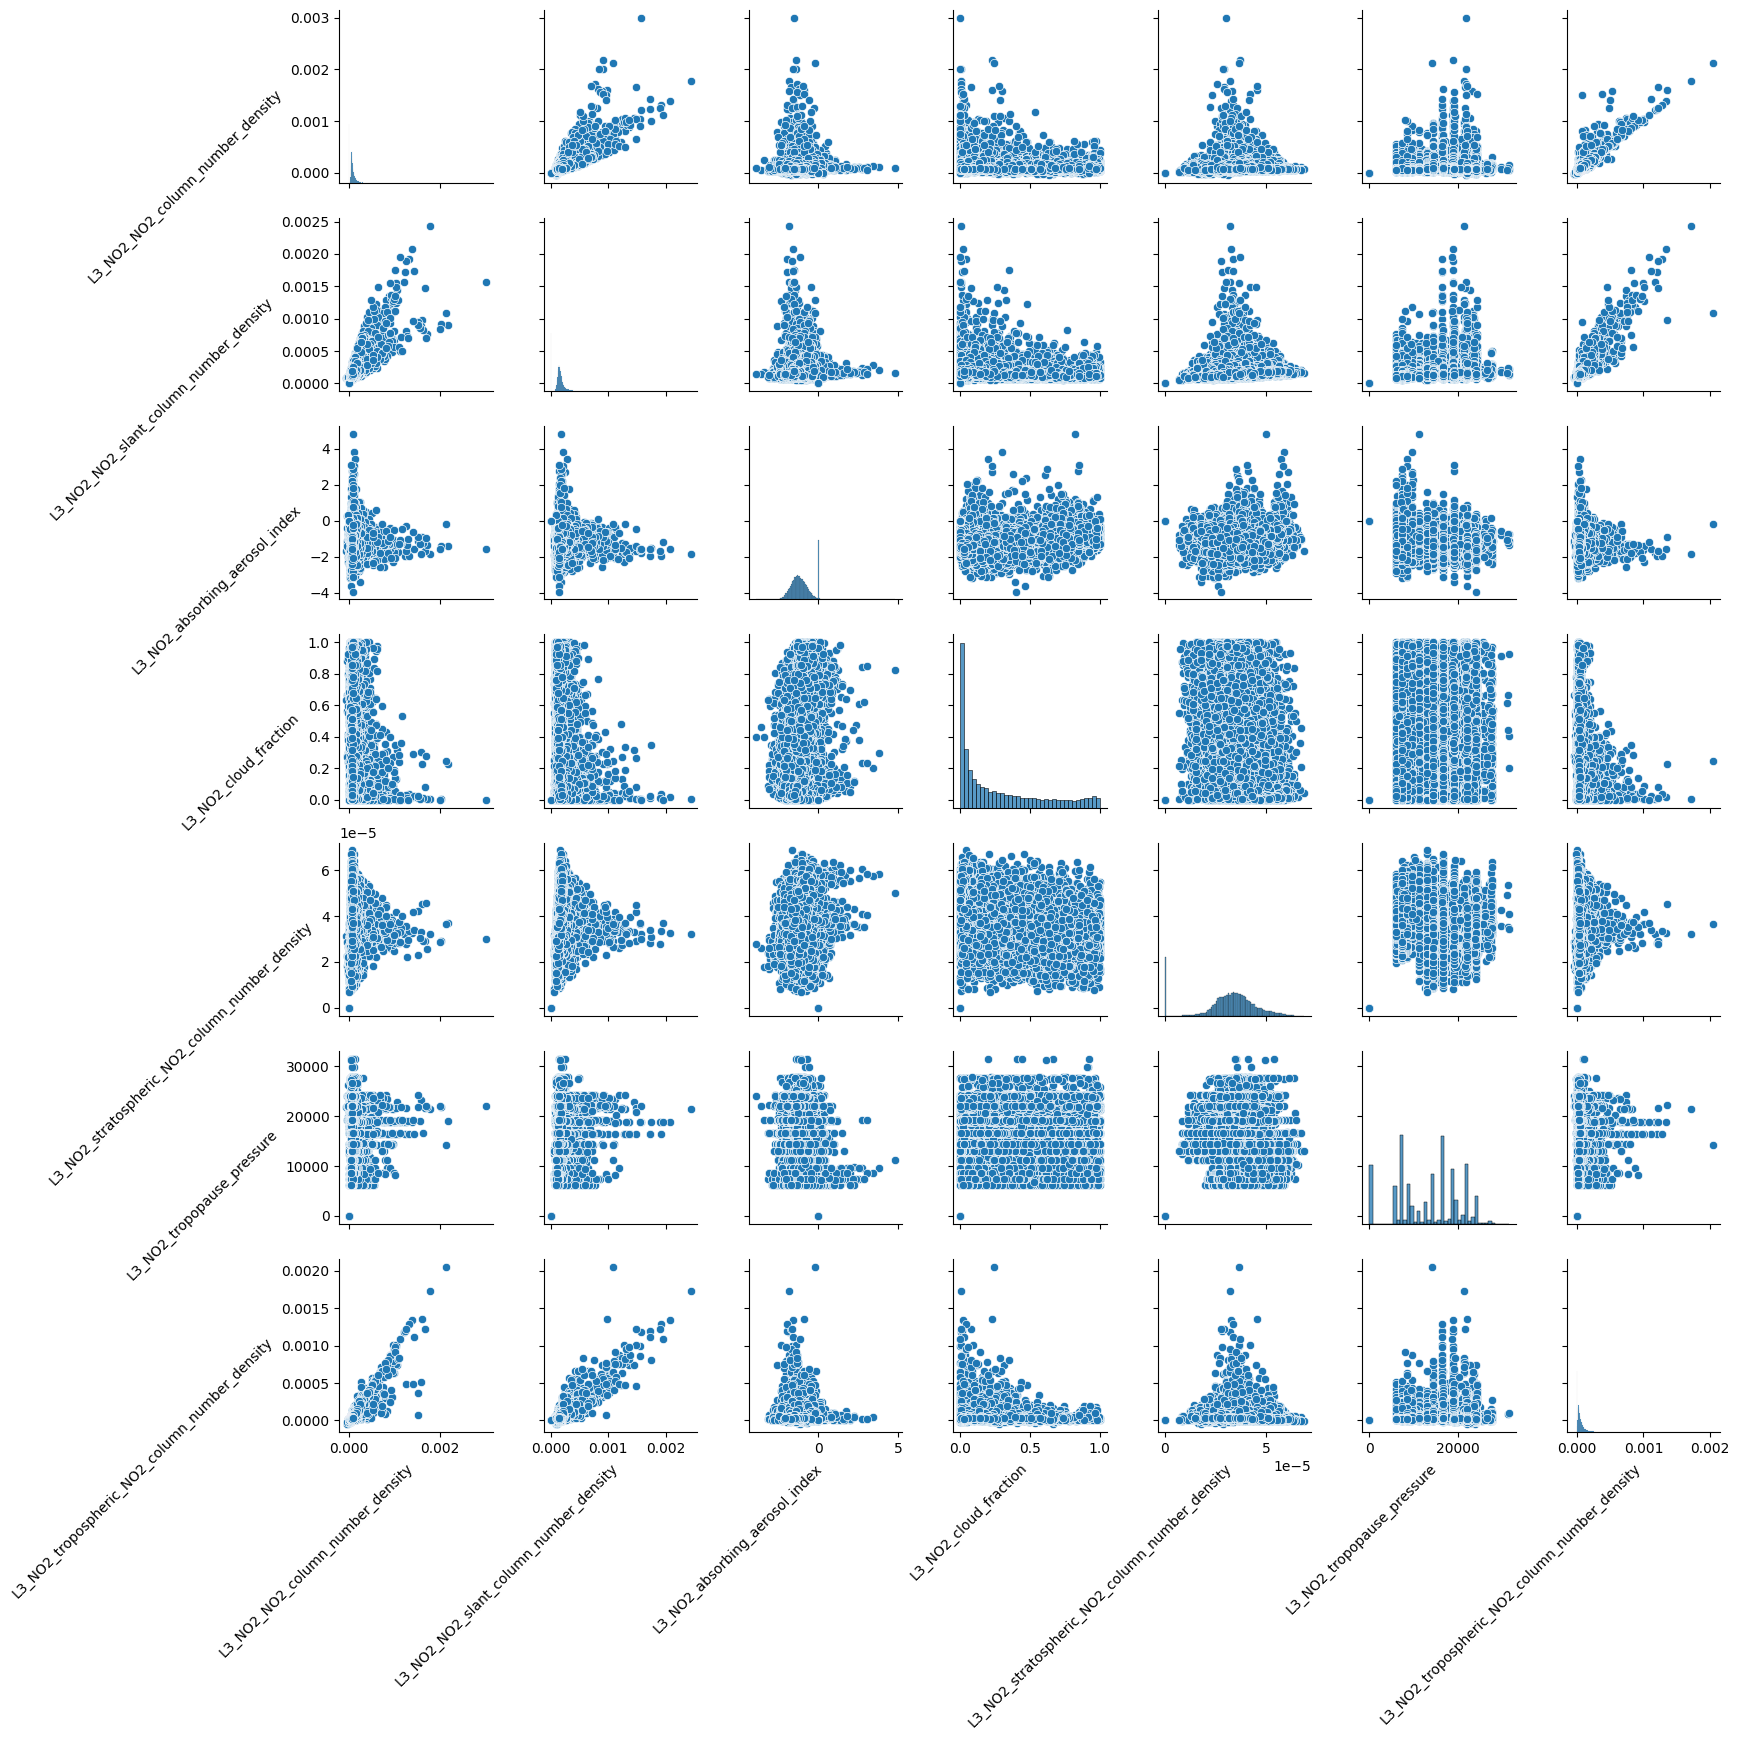

In [12]:
# check for correlations between the L3_NO2 columns
df_NO2 = df_filtered[
	[
		"L3_NO2_NO2_column_number_density",
		"L3_NO2_NO2_slant_column_number_density",
		"L3_NO2_absorbing_aerosol_index",
		"L3_NO2_cloud_fraction",
		"L3_NO2_stratospheric_NO2_column_number_density",
		"L3_NO2_tropopause_pressure",
		"L3_NO2_tropospheric_NO2_column_number_density"
	]
]
# Verwende PairGrid für mehr Kontrolle
g = sns.PairGrid(df_NO2)
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)

for i in range(len(g.axes)):
    for j in range(len(g.axes[i])):
        ax = g.axes[i][j]
        # X-Achsen-Label drehen (nur für untere Reihe)
        if i == len(g.axes) - 1:
            ax.set_xlabel(ax.get_xlabel(), rotation=45, ha='right')
        # Y-Achsen-Label drehen (nur für linke Spalte)
        if j == 0:
            ax.set_ylabel(ax.get_ylabel(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Missing values

In [13]:
# drop rows related to CH4 as 80% of the data is missing
ch4_columns_to_drop = [
    "L3_CH4_CH4_column_volume_mixing_ratio_dry_air", 
    "L3_CH4_aerosol_height", 
    "L3_CH4_aerosol_optical_depth"
]
df_filtered = df_filtered.drop(columns=ch4_columns_to_drop)
print(df_filtered.shape)


(30557, 38)


In [14]:
nans_sum_perc(df_filtered)

,NaN Count,NaN %
L3_NO2_NO2_column_number_density,2189,7.16
L3_NO2_NO2_slant_column_number_density,2189,7.16
L3_NO2_absorbing_aerosol_index,2189,7.16
L3_NO2_cloud_fraction,2189,7.16
L3_NO2_stratospheric_NO2_column_number_density,2190,7.17
L3_NO2_tropopause_pressure,2190,7.17
L3_NO2_tropospheric_NO2_column_number_density,8669,28.37
L3_O3_O3_column_number_density,283,0.93
L3_O3_O3_effective_temperature,283,0.93
L3_O3_cloud_fraction,283,0.93


In [ ]:
# replace NaN values with mean for numerical columns